# University Related Coronavirus Sentiment Analysis


## Tucker Miles and Vicki Tang - November 19, 2020

---

### Approach Description

We plan to start by harvesting tweets from Twitter accounts of two categories: UT Administration/Faculty/Staff and UT students/general population. The textual sentiment of these tweets will be calculated and compared during pre and post COVID-19 time periods, and we will compare the general attitudes of the tweets from these group's social media presence. Further comparison could include searching for correlation between sentiment and COVID-19 rates and other metrics. Also, comparison of this data between universities and looking at word frequencies could potentially lead to interesting findings. We will initially use a scraper to avoid Twitter's weak API for data gathering, and plan on using Jupyter Notebooks with numerous of the powerful data science libraries available for use in Python (NumPy, Pandas, Matplotlib, SciPy, TensorFlow, etc).

### Brief Outline

1. Cleaning
    - Tokenization
    - Normalization
    - Noise Removal
2. Modeling
    - Form training & testing datasets
    - Build & Test model
    - Use model to classify our Tweets
    - Visualizations & insights
3. VADER analysis
    - Visualizations & insights
4. Improvements & Looking Forward

## Tokenizing the Data
---

There are numerous ways we can "clean" our data to make our final predicitions better. First, we will do what is called "tokenizing."
This process will take the Tweets as a whole, and split it into smaller subsections called tokens. These tokens make it much
easier for machines to understand the context of the text when developing the model.

In [1]:
import nltk
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/tucker/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


Fortunately, NLTK contains another helpful resource known as ```punkt```. This is a pre-trained model that allows us to easily tokenize our data.

To get the ```punkt``` resrouce, we run the following command:

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/tucker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now we are able to utilize NLTK's powerful tokenization tools. We simply use the ```.tokenized()``` method in order to tokenize our data.

To demonstrate how this works, let's tokenize ```negative_tweets.json```

In [3]:
print('Not Tokenized:')
print(twitter_samples.strings('negative_tweets.json')[0])   # String
print()
print('Tokenized:')
print(twitter_samples.tokenized('negative_tweets.json')[0]) # The same string, tokenized

Not Tokenized:
hopeless for tmr :(

Tokenized:
['hopeless', 'for', 'tmr', ':(']


Let's go ahead and tokenize ```positive_tweets.json``` for later:

In [4]:
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
print(tweet_tokens[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


## Normalizing the Data
---

Normalization, in terms of natural language processing, is the process of transforming a text into a canonical (standard) form.
For example, "gooood," and "gud" can be resolved to the normalized form "good." This can also apply for different tenses of the same word. For example, "ran," "runs," and "running" are all forms of "run."

<br/>

**There are a few things at work here:**

Stemming is the process of removing suffixes and prefixes from words. As an example, it reduces the inflection in words such as "troubled" and "troubles" to their root form "trouble."

Here are some stemming examples made using Porters Algorithm, one of the most common stemming algorithms:

<html>
<img src="Documents/StemmingExample.PNG" alt="drawing" width="275"/>
</html>

Lemmatization is similar to stemming, but rather than just cutting off the affixes, it will transform the word to it's root. As an example, it may transform the word "better" to "good."

Here are some examples of lemmatization using a dictionary mapping for the translations:

<html>
<img src="Documents/LemmatizationExample.PNG" alt="drawing" width="275"/>
</html>

<br/>
<br/>


This processing is essential for noisy social-media posts, as abbreviations and mispellings are very common!

We will be using lemmatization for our data, so let's download ```wordnet```, a lexical database, and ```averaged_perceptron_tagger```, which will help us in determining context

In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/tucker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tucker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Before using the lemmatizer, we must determine the context of each word within our tweets. To do this, we use what's called a tagging algorithm. Fortunately, NLTK provides a function for this.

Let's test it here:

In [6]:
from nltk.tag import pos_tag
print(pos_tag(tweet_tokens[0]))

[('#FollowFriday', 'JJ'), ('@France_Inte', 'NNP'), ('@PKuchly57', 'NNP'), ('@Milipol_Paris', 'NNP'), ('for', 'IN'), ('being', 'VBG'), ('top', 'JJ'), ('engaged', 'VBN'), ('members', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('community', 'NN'), ('this', 'DT'), ('week', 'NN'), (':)', 'NN')]


Here are some common tags and their meaning:
- NNP: Noun, proper, singular
- NN: Noun, common, singular or mass
- IN: Preposition or conjunction, subordinating
- VBG: Verb, gerund or present participle
- VBN: Verb, past participle

Using the fact that tags starting with ``NN`` are typically nouns, and tags starting with ```VB``` are typically verbs, we can incorporate this into a function to lemmatize our data:

In [7]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

This function gets the position tag of each token in the tweet, and lemmatizes accordingly.
Let's test it here:

In [8]:
print('Not Lemmatized:')
print(tweet_tokens[0])
print()
print('Lemmatized:')
print(lemmatize_sentence(tweet_tokens[0]))

Not Lemmatized:
['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

Lemmatized:
['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


## Removing Noise from the Data
---

There is a lot of noise in tweets. Things such as hyperlinks, twitter handles, and some punctuation must be removed. That is what we will do here

To remove hyperlinks, we'll search for substrings ```http://``` and ```https://``` followed by the rest of the address. Once found, we will replace with an empty string.

In [9]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

This function removes noise and also incorporates the normalization and lemmatization as seen earlier. As arguments, it takes Tweet tokens and a stop words tuple.

Once again, NLTK is of great help here, as it provides a great stopwords set for us to use.

In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/tucker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's briefly test this:

In [11]:
print('Not Cleaned:')
print(tweet_tokens[0])
print()
print('Cleaned:')
print(remove_noise(tweet_tokens[0], stop_words))

Not Cleaned:
['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

Cleaned:
['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


Now, we've removed all mentions, removed all stop words, and have made everything lowercase.

Next, let's go ahead and use this function to clean up the Tweets we saved earlier:

In [12]:
# Grab our pre-classified Tweets
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

# Clean them
for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [13]:
print(positive_tweet_tokens[0])
print()
print(positive_cleaned_tokens_list[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


Much, much better! All of this processing will allow our model to be much more accurate!

## Word Density
---

One of the simplest forms of textual analysis is a simple word frequency. Let's take a quick look at the frequencies of words in some of these data sets.

In [14]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)

This is a generator function which will take a list of tokens as an argument and will provide a list of all of the words.

Now that we've combined all of the positive tweets, let's see what the most popular ones are. Once again, NLTK comes to the rescue!

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253), ('u', 245), ('day', 242), ('like', 229), ('see', 195), ('happy', 192)]


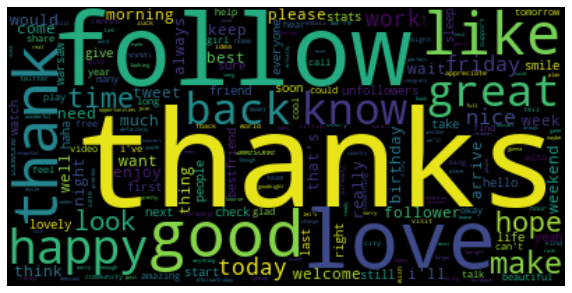

In [15]:
from nltk import FreqDist
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Calculate frequency distribution
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(15))

# Filter
filter_words = dict([(m, n) for m, n in freq_dist_pos.items() if len(m) > 3])
wcloud = WordCloud().generate_from_frequencies(filter_words)

# Plot the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

And now for the negatives:

[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218), ('♛', 210), ('》', 210), ('u', 193), ("can't", 180), ('time', 160)]


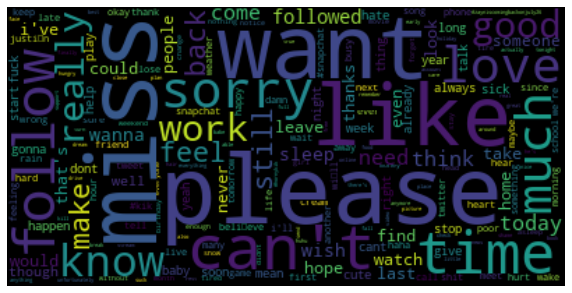

In [16]:
# Calculate frequency distribution
freq_dist_neg = FreqDist(all_neg_words)
print(freq_dist_neg.most_common(15))

# Filter
filter_words = dict([(m, n) for m, n in freq_dist_neg.items() if len(m) > 3])
wcloud = WordCloud().generate_from_frequencies(filter_words)

# Plot the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Interesting. It's clear that emoticons are very common in both positive and negative Tweets, and they lead the frequency counts in both cases! It's very interesting how you can begin to see some overall sentiment just from this frequency analysis, with the positive Tweets commonly having words such as "thanks," "love, " and "happy" while common negatives are "please," "can't,", and "miss."

So, to summarize a bit, so far we have extracted tweets from NLTK, tokenized them, normalized them, and cleaned them up. Then, we did some basic frequency analysis on positive and negative Tweet datasets. Let's move on to modeling!

## Prepping for Model
---

To make a model, we need to create a training set to train our model. This is known as supervised learning, the task of learning a function that maps an input to an output based on example input-output pairs. We must associate our datasets with a sentiment, and these is where our datasets of positive and negative datasets comes in. Here, we will train our model to classify into two categories, positive and negative. In order to do this, we will need to split our dataset into parts, one part for training the model and the another part for testing its accuracy.

We will be using the Naive Bayes Classifier in NLTK. If you've taken a statistics class, you've probably heard of Bayes' Thereom, and that is what this classifier is based on.

To use the Naive Bayes Classfier in NLTK, we must convert our tokens to a dictionary with the words being the keys and the value being True.

Let's create a generator function which will convert the clean tokens to dictionaries with the words being the keys and the values all being True:

In [17]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

As mentioned earlier, we have to split our dataset. Part of it will be used for training, and the other for testing.

In [18]:
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

# Combine positive and negative dataset
dataset = positive_dataset + negative_dataset

# Shuffle to avoid any possible bias
random.shuffle(dataset)

# First 7000
train_data = dataset[:7000]

# Remaining 3000
test_data = dataset[7000:]

This attaches a sentiment to each tweet, and then combines them. To avoid bias, the combined dataset is shuffled.

After the above code runs, we have 10,000 Tweets to train and test our model with. 7,000 will be used for training while the remaining 3,000 will be used for testing.

## Building and Testing our Model
---

After all of this setup, we are finally to the point where we will build our model. We'll use some handy NLTK functions here: ```train()``` and ```accuracy```.

In [19]:
from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9963333333333333
Most Informative Features
                      :) = True           Positi : Negati =   1648.4 : 1.0
                     sad = True           Negati : Positi =     52.5 : 1.0
                follower = True           Positi : Negati =     30.6 : 1.0
                     bam = True           Positi : Negati =     20.5 : 1.0
                    glad = True           Positi : Negati =     17.8 : 1.0
                    damn = True           Negati : Positi =     15.5 : 1.0
                     x15 = True           Negati : Positi =     14.9 : 1.0
                followed = True           Negati : Positi =     14.1 : 1.0
                 awesome = True           Positi : Negati =     12.7 : 1.0
                    blog = True           Positi : Negati =     11.8 : 1.0
None


The accuracy which was outputted above is the percentage of tweets which the model correctly classified. ~99.6%, not too bad!

We also outputted the most informative features. This shows the ratio of that specific tokens occurence in the positive dataset to the negative dataset. Some more interesting insight into our data here!



Finally, we are to the point that we can pass our classifier a Tweet, and it will return it's sentiment. Let's Test it out!

We'll write our own example for a postive and negative tweet:

In [20]:
negative_tweet = 'Today was a terrible day! I spent forever trying to get my Jupyter Notebook to run properly, but it wouldn\'t budge! :('
positive_tweet = 'Today was amazing! I\'m very happy! :)'
                                                                                                                                        
from nltk.tokenize import word_tokenize

tokens = remove_noise(word_tokenize(negative_tweet))

print(classifier.classify(dict([token, True] for token in tokens)))
                                                                                                                                        
tokens = remove_noise(word_tokenize(positive_tweet))

print(classifier.classify(dict([token, True] for token in tokens)))

Negative
Positive


Working as intended!

With our model set up and working, let's move on to using it for something cool!

## Getting Our Data
---

As mentioned earlier, we are comparing two datasets. One dataset containing Tweets from accounts which are directly associated with and/or  owned by the University, and the other containing Tweets which are related to the university, but not directly associated or owned by the university, such as students.

For the tweets from accounts which are directly associated or owned by the University, we searched for Tweets from these accounts:

Administration:
- @DondePlowman - Donde Plowman
- @randyboyd - Randy Boyd
- @tucarpenter - Tiffany Carpenter
- @UTIA_SVP - Tim Cross
- @KC4UTM - Keith Carver

University Accounts:
- @utknoxville - UT Knoxville
- @utk_tce - UTK TCE
- @utkdos - Office of the Dean of Students
- @ut_admissions - UT Admissions
- @utk_asc - UTK Academic Success Center
- @UTKCEHHS - UTK CEHHS
- @utk_cfs - UTK CFS
- @UTKStudentLife - UTK Student Life
- @UTKCoAD - UTK Arch + Design
- @UTKSOM - UT School of Music
- @tennalum - UT Knoxville Alumni
- @utknursing - UT College of Nursing
- @HaslamUT - Haslam Business

For the tweets from accounts which are not directly associated or owned by the University, we searched for Tweets with these keywords
- utk
- University of Tennessee Knoxville
- Knoxville Tennessee

This data was colleced using the snscrape command line tool, and historically represent the time period of August 1st, 2019 to August 1st, 2020

## Analyzing Admininstration/University-Sanctioned Tweets
---

Now that we, have our data in CSVs, let's use Pandas to read them in:

In [21]:
import pandas as pd

# Extract content and date fields from csv
fields=['date', 'content', 'user/username']
d = pd.read_csv('combined_csv.csv', usecols=fields)

# Create dataframe
tweets_df_1 = pd.DataFrame(data=d)
tweets_df_1

,date,content,user/username
0,2020-08-10T14:13:27+00:00,Marcus Yoder (HCB ‘92) has been appointed seni...,HaslamUT
1,2020-08-07T19:30:08+00:00,Congratulations to the Haslam College of Busin...,HaslamUT
2,2020-08-07T14:14:23+00:00,#FacultyFriday Supply chain management profess...,HaslamUT
3,2020-08-06T19:37:43+00:00,"Due to COVID-19, most internships have switche...",HaslamUT
4,2020-08-06T14:40:37+00:00,Congratulations to MSCM Tri-Con grad Nainika S...,HaslamUT
...,...,...,...
7038,2019-08-04T11:55:30+00:00,2 weeks from tonight is Torch Night. “One that...,DondePlowman
7039,2019-08-03T17:07:33+00:00,This is great news Tom. Thanks for the update....,DondePlowman
7040,2019-08-02T22:56:37+00:00,Having a partner who is the love of your life ...,DondePlowman
7041,2019-08-02T16:39:28+00:00,So impressed with the crowd &amp; the passion ...,DondePlowman


Let's use our model and add a column to our dataframe which represents the sentiment of each Tweet:

In [22]:
sentiment = []
tweets = tweets_df_1['content'].tolist()

# For each tweet, classify it and append model's decision to list
for tweet in tweets:
    tokens = remove_noise(word_tokenize(tweet))
    sentiment.append(classifier.classify(dict([token, True] for token in tokens)))
    
# Add sentiment column to dataframe
tweets_df_1['sentiment'] = sentiment
tweets_df_1

,date,content,user/username,sentiment
0,2020-08-10T14:13:27+00:00,Marcus Yoder (HCB ‘92) has been appointed seni...,HaslamUT,Negative
1,2020-08-07T19:30:08+00:00,Congratulations to the Haslam College of Busin...,HaslamUT,Positive
2,2020-08-07T14:14:23+00:00,#FacultyFriday Supply chain management profess...,HaslamUT,Positive
3,2020-08-06T19:37:43+00:00,"Due to COVID-19, most internships have switche...",HaslamUT,Negative
4,2020-08-06T14:40:37+00:00,Congratulations to MSCM Tri-Con grad Nainika S...,HaslamUT,Positive
...,...,...,...,...
7038,2019-08-04T11:55:30+00:00,2 weeks from tonight is Torch Night. “One that...,DondePlowman,Positive
7039,2019-08-03T17:07:33+00:00,This is great news Tom. Thanks for the update....,DondePlowman,Positive
7040,2019-08-02T22:56:37+00:00,Having a partner who is the love of your life ...,DondePlowman,Positive
7041,2019-08-02T16:39:28+00:00,So impressed with the crowd &amp; the passion ...,DondePlowman,Positive


Let's also take a quick look at the overall counts:

  Sentiment Count
0  Positive  5200
1  Negative  1843


<AxesSubplot:ylabel='Count'>

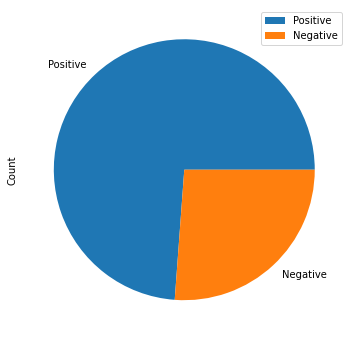

In [23]:
proportions_df_1 = pd.DataFrame(tweets_df_1['sentiment'].value_counts().reset_index().values, columns=["Sentiment", "Count"])
print(proportions_df_1)
proportions_df_1.plot.pie(y='Count', labels=proportions_df_1['Sentiment'], figsize=(6,6))

Nice! Now we have associated a sentiment with each of these Tweets, as seen above!

Pandas doesn't like ISO 8601 time format, so let's use a lambda to change the dates to something readable by Pandas:

In [24]:
import dateutil.parser

# Convert ISO 8601 time format to be readable by pandas
tweets_df_1['date'] = tweets_df_1['date'].apply(lambda x: dateutil.parser.parse(x))

Let's use groupby to get the number of positive and negative Tweets for each week in our time period:

In [25]:
# Create month/year column
tweets_df_1['month/year'] = tweets_df_1['date'].apply(lambda x: "%d/%d" % (x.month, x.year))

# create column to sort off of
months = ['8/2019', '9/2019', '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020']
mapping = {day: i for i, day in enumerate(months)}
tweets_df_1['sorter'] = tweets_df_1['month/year'].map(mapping)
tweets_df_1 = tweets_df_1.sort_values(by='sorter')

# Remove August since it was only partially collected
tweets_df_1 = tweets_df_1[tweets_df_1['sorter'] != 12]
tweets_df_1

,date,content,user/username,sentiment,month/year,sorter
7042,2019-08-02 10:30:34+00:00,More good news about UTK from US News rankings...,DondePlowman,Positive,8/2019,0
1861,2019-08-22 00:13:29+00:00,More cowbell. https://t.co/A8rggcLVj6,KC4UTM,Negative,8/2019,0
1860,2019-08-22 11:20:01+00:00,@WBBJ7Julia @utmartin @WBBJ7News @wbbj7joshr @...,KC4UTM,Negative,8/2019,0
1859,2019-08-23 01:20:21+00:00,Hey...somebody’s got to do it.. https://t.co/I...,KC4UTM,Positive,8/2019,0
1858,2019-08-23 02:10:09+00:00,If no one has ever asked you to carry a bushel...,KC4UTM,Negative,8/2019,0
...,...,...,...,...,...,...
4821,2020-07-13 16:49:54+00:00,Changes to course schedules have been made to ...,UTKnoxville,Negative,7/2020,11
4820,2020-07-13 16:49:54+00:00,(2/4) For general information on interpreting ...,UTKnoxville,Negative,7/2020,11
4818,2020-07-13 16:49:55+00:00,(4/4) We ask for your patience when contacting...,UTKnoxville,Negative,7/2020,11
4819,2020-07-13 16:49:54+00:00,"(3/4) For tuition, fees, or financial aid ques...",UTKnoxville,Negative,7/2020,11


Let's use groupby to get the number of positive and negative Tweets for each week in our time period:

In [26]:
tweets_df_grouped_1 = tweets_df_1.groupby(['sorter', 'sentiment']).size()
tweets_df_grouped_1

sorter  sentiment
0       Negative     149
        Positive     411
1       Negative     152
        Positive     443
2       Negative     169
        Positive     444
3       Negative     138
        Positive     499
4       Negative     140
        Positive     280
5       Negative     136
        Positive     387
6       Negative     138
        Positive     364
7       Negative     204
        Positive     629
8       Negative     211
        Positive     492
9       Negative     127
        Positive     497
10      Negative     127
        Positive     328
11      Negative     112
        Positive     325
dtype: int64

As you can see above, we now have grouped our data into months, and have counted the number of positive and negative Tweets within each month!

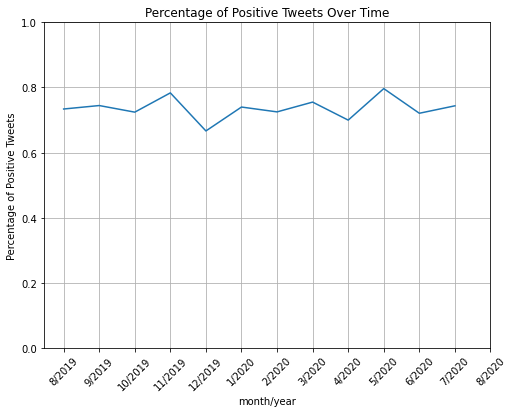

In [27]:
import numpy as np
from matplotlib import pyplot as plt

# Group pos/neg values into separate lists
N = 2
count_tuples = [tweets_df_grouped_1.values[n:n+N] for n in range(0, len(tweets_df_grouped_1.values), N)]

# Calculate percentage of positives each month
pos_percentages_1 = []
for group in count_tuples:
    pos_percentages_1.append(group[1] / sum(group))

# Plot
plt.figure(figsize=(8,6))
plt.plot(pos_percentages_1)
plt.xticks(np.arange(13), months, rotation=45)
plt.ylim(0, 1)
plt.xlabel('month/year')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets Over Time')
plt.grid()
plt.show()

[Text(0, 0, '8/2019'),
 Text(1, 0, '9/2019'),
 Text(2, 0, '10/2019'),
 Text(3, 0, '11/2019'),
 Text(4, 0, '12/2019'),
 Text(5, 0, '1/2020'),
 Text(6, 0, '2/2020'),
 Text(7, 0, '3/2020'),
 Text(8, 0, '4/2020'),
 Text(9, 0, '5/2020'),
 Text(10, 0, '6/2020'),
 Text(11, 0, '7/2020')]

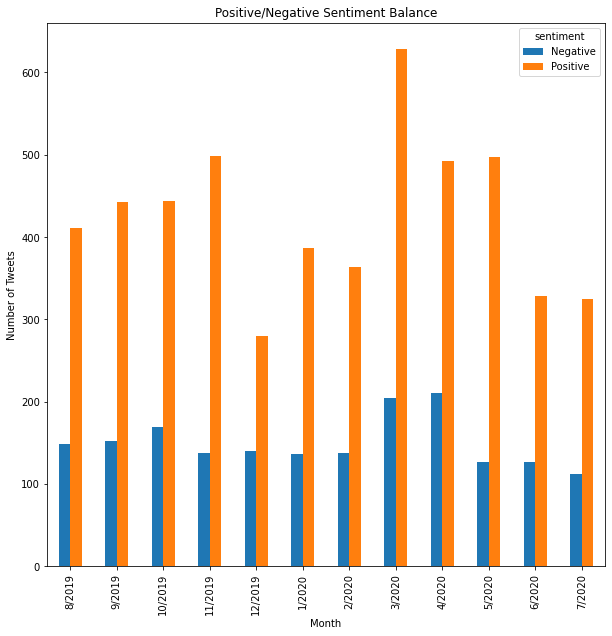

In [28]:
# Plot Pos/Neg balance month-to-month
ax_1 = tweets_df_grouped_1.unstack().plot.bar(xlabel='Month',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(10, 10))
ax_1.set_xticklabels(months[:-1])

Interesting graphic here! The the ratio of positive to negative Tweets is very one sided in most months, leaning heavily on the positive side. Some interesting things to note here. In March, when things began closing down and switching up due to the pandemic, we see the highest number of positive Tweets out of all months! We propose this could be due to encouragement from campus leaders to stay strong when things were beginning to get rough, and to continue with the constant encouragement they tend to display.The negative Tweets seem to be fairly constant throughout, but with peaks in March and April, around the begining of the pandemic. Another cool insight!

The two most heavily positive months were November 2019 and March 2020. Out of curiosity, and because of the fact that we 
really began to feel the pressure of the pandemic in March, let's take a closer look at March specifically:

<ipython-input-29-559630486464>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_1['day'] = daily_1['date'].apply(lambda x: "%d" % (x.day))
<ipython-input-29-559630486464>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_1['day'] = daily_1['day'].astype(int)


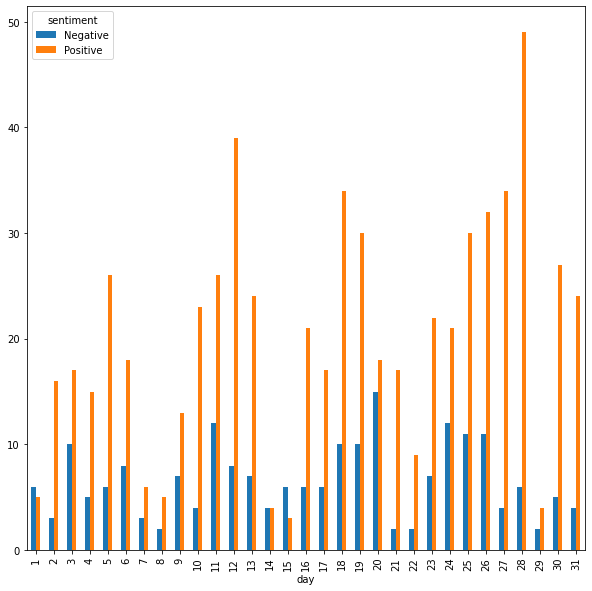

In [29]:
# Create boolean mask to filter out March
mask = (tweets_df_1['month/year'] == '3/2020')

# Apply mask, type cast, and sort
daily_1 = tweets_df_1[mask]
daily_1['day'] = daily_1['date'].apply(lambda x: "%d" % (x.day))
daily_1['day'] = daily_1['day'].astype(int)
daily_1 = daily_1.sort_values(by='day')

# Group
test_grouped_1 = daily_1.groupby(['day', 'sentiment']).size()

# Plot
daily_grouped_1 = test_grouped_1.unstack().plot.bar(figsize=(10, 10))

A couple of key dates to note:

- March 11, 2020 - World Health Organization declared Coronavirus a pandemic
- March 11, 2020 - Email sent to students announcing initial temporary move to online classes
- March 12, 2020 - State of Tennessee declares state of emergency
- March 16, 2020 - Email sent to students announcing semester-long move to online classes
- march 28, 2020 - Global deaths surpass 30,000

On an unrelated note, it's very interesting to see how activity decreases so much on the weekend, and makes me wonder if real data scientists ever unintentionally come across beneficial information.

**Recap**

The above analyses bring about some interesting discourse and gives us some nice visuals to analyze; however, there are a few drawbacks. The biggest of these drawbacks would be the fact that our model is a binary classifier, meaning it classifies the Tweets into only two categories, positive or negative. This can be misleading as neutral Tweets are common, and this approach forces the model to place one of these labels onto each Tweet.

However, there are more ways to analyze this, which we will get into now!

## Vader Sentiment Analysis
---

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a very powerful tool which will allow us to analyze our data in a much more specific manner. Even better, this tool is specifically adapted to sentiments which are expressed in social media.

This analysis is based on lexicons of sentiment-related words. A lexicon is taken, and each word is ranked not only as positive or negative, but how positive and negative it may be.

Here's an example of some words, and their associated sentiment ratings:

<html>
<img src="Documents/Vader Lexicon Excerpt.PNG" alt="drawing" width="700"/>
</html>


These words have been manually rated by humans, and if VADER's lexicon provides good coverage of the words in your data, it provides accurate, quick results.

Let's test it out:

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
      
    print("Overall sentiment dictionary is : ", sentiment_dict) 
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
    print("Sentence Overall Rated As", end = " ") 
  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        print("Positive") 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        print("Negative") 
  
    else : 
        print("Neutral") 

The above function takes the sentence argument, uses VADER to analyze it, and prints out the results, as shown below

In [31]:
sentence = "Today was an amazing day! The weather was nice, and we all had a blast :)"
sentiment_scores(sentence)

Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'compound': 0.8718}
sentence was rated as  0.0 % Negative
sentence was rated as  56.8 % Neutral
sentence was rated as  43.2 % Positive
Sentence Overall Rated As Positive


You can see that the text is given a rating for negative, neutral, and positive. The compound number is a representation of all 3. It is normalized to be between -1 and 1, with -1 being completely negative, 1 being completely positive, and 0 being neutral

This will enable us to get a better look at the historic sentiment of our Tweets. Let's first analyze the Tweets of our admin/university-sanctioned dataset. We'll set that up here:

In [32]:
# Extract content and date fields from csv
fields=['date', 'content']
d = pd.read_csv('combined_csv.csv', usecols=fields)

# Create dataframe
tweets_df_1 = pd.DataFrame(data=d)

# Calculate polarity scores and store compound result into vals
sid_obj = SentimentIntensityAnalyzer() 

vals = []

tweets = tweets_df_1['content'].tolist()
for tweet in tweets:
    sentiment_dict = sid_obj.polarity_scores(tweet)
    vals.append(sentiment_dict['compound'])

# Add vals to dataframe
tweets_df_1['compound'] = vals 

# Concert ISO 8601 time format to be readable by pandas
tweets_df_1['date'] = tweets_df_1['date'].apply(lambda x: dateutil.parser.parse(x))

# Set index as the data
tweets_df_1.index = tweets_df_1['date']

# Drop content column and resample on a weekly basis, calculating the mean of each month
data_1 = tweets_df_1.drop(columns=['content']).resample('M').mean()

data_1

,compound
date,
2019-08-31 00:00:00+00:00,0.457304
2019-09-30 00:00:00+00:00,0.465794
2019-10-31 00:00:00+00:00,0.450072
2019-11-30 00:00:00+00:00,0.553641
2019-12-31 00:00:00+00:00,0.394545
2020-01-31 00:00:00+00:00,0.435599
2020-02-29 00:00:00+00:00,0.480479
2020-03-31 00:00:00+00:00,0.423068
2020-04-30 00:00:00+00:00,0.458488


And just like that, we have grouped our Tweets by week and have calculated the VADER compound score on each chunk.

Let's plot this value over time:

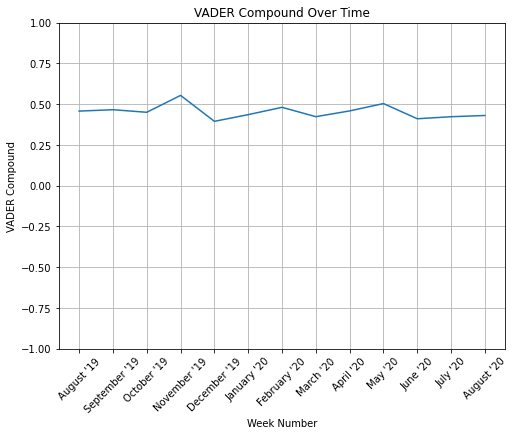

In [33]:
import matplotlib.pyplot as plt
import numpy as np

xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels = ['August \'19', 'September \'19', 'October \'19', 'November \'19', 'December \'19',
          'January \'20', 'February \'20', 'March \'20', 'April \'20', 'May \'20', 'June \'20',
          'July \'20', 'August \'20']

plt.figure(figsize=(8, 6))
plt.ylim(-1, 1)
plt.xticks(xticks, labels, rotation=45)
plt.grid()
plt.plot(np.arange(1, 14), data_1)
plt.xlabel('Week Number')
plt.ylabel('VADER Compound')
plt.title('VADER Compound Over Time')
plt.show()

Pretty stable month-to-month, with the lowest overall sentiment being in December 2019

## Analyzing Non Admininstration/University-Sanctioned Tweets
---

Now, let's look at the same visuals for our other dataset, and we'll start by calculating the sentiment for each Tweet:

In [34]:
import pandas as pd

# Extract content and date fields from csv
fields=['date', 'content', 'user/username']
d = pd.read_csv('combinedNonUniLessSkewed.csv', usecols=fields)

# Create dataframe
tweets_df_2 = pd.DataFrame(data=d)

# Determine sentiment and add to dataframe
sentiment = []
tweets = tweets_df_2['content'].tolist()
for tweet in tweets:
    tokens = remove_noise(word_tokenize(tweet))
    sentiment.append(classifier.classify(dict([token, True] for token in tokens)))
    
tweets_df_2['sentiment'] = sentiment

Then showing the proportions of positive to negative Tweets:

  Sentiment Count
0  Positive  2855
1  Negative  1933


<AxesSubplot:ylabel='Count'>

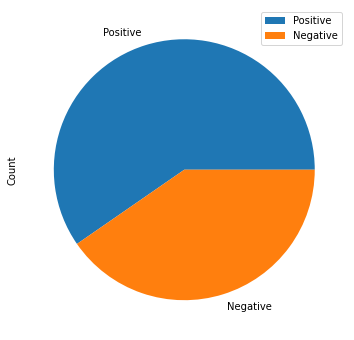

In [35]:
proportions_df_2 = pd.DataFrame(tweets_df_2['sentiment'].value_counts().reset_index().values, columns=["Sentiment", "Count"])
print(proportions_df_2)
proportions_df_2.plot.pie(y='Count', labels=proportions_df_2['Sentiment'], figsize=(6,6))

Group them by month:

In [36]:
import dateutil.parser

# Convert ISO 8601 time format to be readable by pandas
tweets_df_2['date'] = tweets_df_2['date'].apply(lambda x: dateutil.parser.parse(x))

# Create month/year column
tweets_df_2['month/year'] = tweets_df_2['date'].apply(lambda x: "%d/%d" % (x.month, x.year))

# create column to sort off of
months = ['8/2019', '9/2019', '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020', '5/2020', '6/2020', '7/2020', '8/2020']
mapping = {day: i for i, day in enumerate(months)}
tweets_df_2['sorter'] = tweets_df_2['month/year'].map(mapping)
tweets_df_2 = tweets_df_2.sort_values(by='sorter')

tweets_df_grouped_2 = tweets_df_2.groupby(['sorter', 'sentiment']).size()
tweets_df_grouped_2

sorter  sentiment
0.0     Negative      43
        Positive      59
1.0     Negative      75
        Positive     104
2.0     Negative      56
        Positive      82
3.0     Negative      69
        Positive      69
4.0     Negative      52
        Positive      91
5.0     Negative      88
        Positive     108
6.0     Negative     174
        Positive     237
7.0     Negative     280
        Positive     424
8.0     Negative     245
        Positive     423
9.0     Negative     332
        Positive     519
10.0    Negative     247
        Positive     410
11.0    Negative     244
        Positive     307
dtype: int64

Plot the percentage of positive Tweets over time:

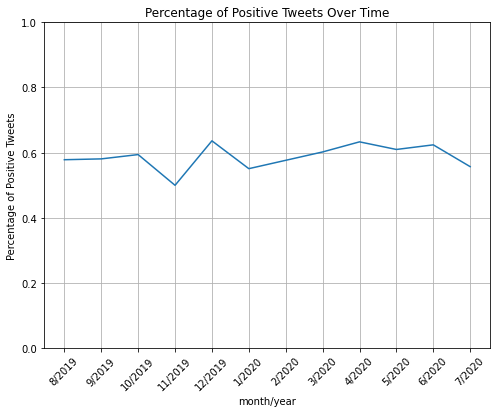

In [37]:
import numpy as np
from matplotlib import pyplot as plt

# Group pos/neg values into separate lists
N = 2
count_tuples = [tweets_df_grouped_2.values[n:n+N] for n in range(0, len(tweets_df_grouped_2.values), N)]

# Calculate percentage of positives each month
pos_percentages_2 = []
for group in count_tuples:
    pos_percentages_2.append(group[1] / sum(group))

# Plot
plt.figure(figsize=(8,6))
plt.plot(pos_percentages_2)
plt.xticks(np.arange(12), months[:-1], rotation=45)
plt.ylim(0, 1)
plt.xlabel('month/year')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets Over Time')
plt.grid()
plt.show()

Plot the positive/negative balance for each month:

[Text(0, 0, '8/2019'),
 Text(1, 0, '9/2019'),
 Text(2, 0, '10/2019'),
 Text(3, 0, '11/2019'),
 Text(4, 0, '12/2019'),
 Text(5, 0, '1/2020'),
 Text(6, 0, '2/2020'),
 Text(7, 0, '3/2020'),
 Text(8, 0, '4/2020'),
 Text(9, 0, '5/2020'),
 Text(10, 0, '6/2020'),
 Text(11, 0, '7/2020')]

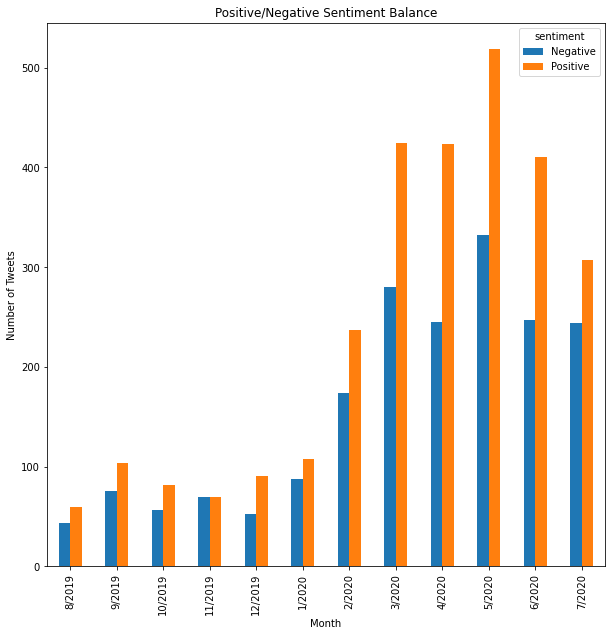

In [38]:
# Plot Pos/Neg balance month-to-month
ax_2 = tweets_df_grouped_2.unstack().plot.bar(xlabel='Month',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(10, 10))
ax_2.set_xticklabels(months[:-1])

As you can see, the number of Tweets in our time epriod is very lopsided. We really struggled with trying to build a good dataset for this portion of our project, as it is much, much harder to get Tweets based off of keywords rather than gathering Tweets from a predetermined user base. Compared to the other balance plot, the balance of positive to negative Tweets is much more balnced, as predicted.

Then run VADER:

In [39]:
import datetime

# Extract content and date fields from csv
fields=['date', 'content']
d = pd.read_csv('combinedNonUniLessSkewed.csv', usecols=fields)

# Create dataframe
tweets_df_2 = pd.DataFrame(data=d)

# Calculate polarity scores and store compound result into vals
sid_obj = SentimentIntensityAnalyzer() 

vals = []

tweets = tweets_df_2['content'].tolist()
for tweet in tweets:
    sentiment_dict = sid_obj.polarity_scores(tweet)
    vals.append(sentiment_dict['compound'])

# Add vals to dataframe
tweets_df_2['compound'] = vals 

# Concert ISO 8601 time format to be readable by pandas
tweets_df_2['date'] = tweets_df_2['date'].apply(lambda x: dateutil.parser.parse(x))

# Set index as the data
tweets_df_2.index = tweets_df_2['date']

tweets_df_2 = tweets_df_2[tweets_df_2['date'] < '2020-09-01 00:00:00+00:00']

# Drop content column and resample on a weekly basis, calculating the mean of each month
data_2 = tweets_df_2.drop(columns=['content']).resample('M').mean()

And plot the results:

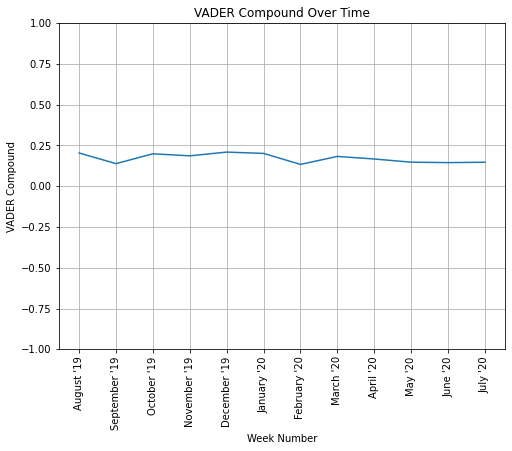

In [40]:
import matplotlib.pyplot as plt
import numpy as np

xticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
labels = ['August \'19', 'September \'19', 'October \'19', 'November \'19', 'December \'19',
          'January \'20', 'February \'20', 'March \'20', 'April \'20', 'May \'20', 'June \'20',
          'July \'20', 'August \'20']

plt.figure(figsize=(8, 6))
plt.ylim(-1, 1)
plt.xticks(xticks, labels, rotation=90)
plt.grid()
plt.plot(np.arange(1, 13), data_2)
plt.xlabel('Week Number')
plt.ylabel('VADER Compound')
plt.title('VADER Compound Over Time')
plt.show()

Once again, this view is consistent, but is overall lower than the previous VADER analysis.

## Comparison Between the Two

---

To see if we can gain any more insight from our data, let's compare plot some of the data together and compare the visuals:

**Positive/Negative overall proportions comparison:**

<AxesSubplot:ylabel='Count'>

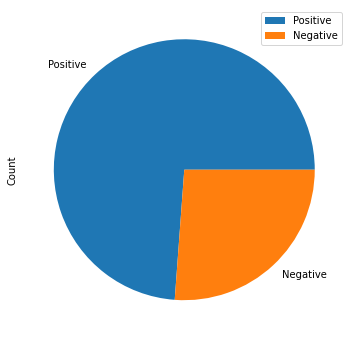

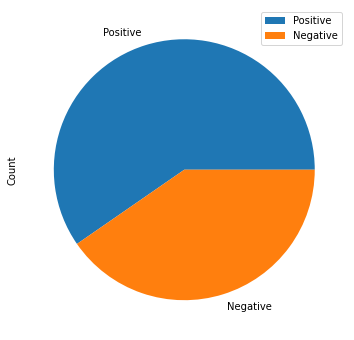

In [65]:
proportions_df_1.plot.pie(y='Count', labels=proportions_df_2['Sentiment'], figsize=(6,6))

proportions_df_2.plot.pie(y='Count', labels=proportions_df_2['Sentiment'], figsize=(6,6))

**Positive Percentage over time:**

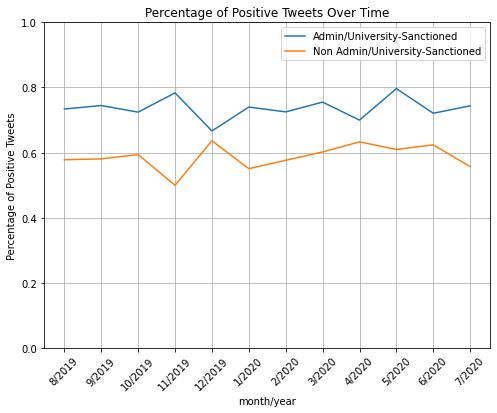

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(pos_percentages_1, label='Admin/University-Sanctioned')
plt.plot(pos_percentages_2, label='Non Admin/University-Sanctioned')
plt.xticks(np.arange(12), months[:-1], rotation=45)
plt.ylim(0, 1)
plt.xlabel('month/year')
plt.ylabel('Percentage of Positive Tweets')
plt.title('Percentage of Positive Tweets Over Time')
plt.grid()
plt.legend()

plt.show()

[Text(0, 0, '8/2019'),
 Text(1, 0, '9/2019'),
 Text(2, 0, '10/2019'),
 Text(3, 0, '11/2019'),
 Text(4, 0, '12/2019'),
 Text(5, 0, '1/2020'),
 Text(6, 0, '2/2020'),
 Text(7, 0, '3/2020'),
 Text(8, 0, '4/2020'),
 Text(9, 0, '5/2020'),
 Text(10, 0, '6/2020'),
 Text(11, 0, '7/2020')]

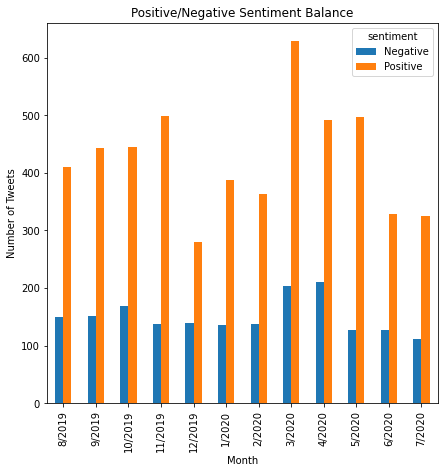

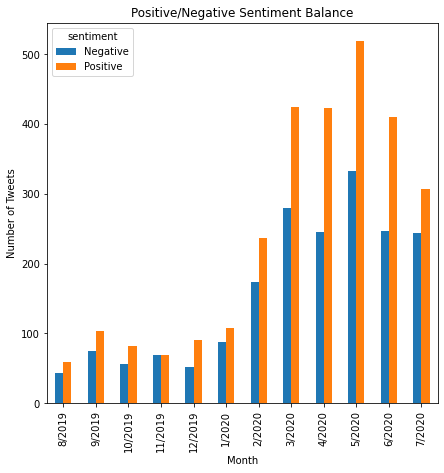

In [69]:
ax_1 = tweets_df_grouped_1.unstack().plot.bar(xlabel='Month',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(7, 7))
ax_1.set_xticklabels(months[:-1])

ax_2 = tweets_df_grouped_2.unstack().plot.bar(xlabel='Month',\
                                     ylabel='Number of Tweets',\
                                     title='Positive/Negative Sentiment Balance',\
                                     figsize=(7, 7))
ax_2.set_xticklabels(months[:-1])

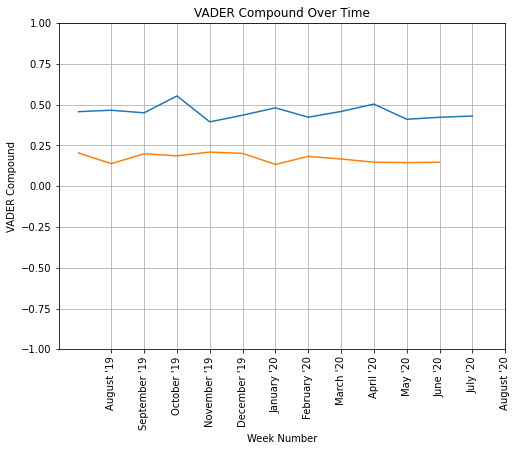

In [75]:
plt.figure(figsize=(8, 6))
plt.plot(data_1.values, label='Admin/University-Sanctioned')
plt.plot(data_2.values, label='Non Admin/University-Sanctioned')
plt.xticks(xticks, labels, rotation=90)
plt.ylim(-1, 1)
plt.xlabel('Week Number')
plt.ylabel('VADER Compound')
plt.title('VADER Compound Over Time')
plt.grid()

plt.show()

## Issues & Looking Forward

---

passage here...